# Лабораторна робота №2

### Студента групи МІТ-31 (підгрупа 1)

### Добровольського Арсенія Михайловича

### Завдання
**Частина 1: Регресія на згенерованому наборі даних**

1. Згенеруйте набір даних для регресії за допомогою sklearn.datasets.make_regression (використати не менше 5 параметрів). Набір даних повинен містити не менше 1000 екземплярів.

2. Розділіть дані на навчальний та тестовий набори у співвідношенні 80% - 20%.

3. Побудуйте модель регресії на навчальних даних та оцініть її точність на тестових даних. Використовуйте будь-який регресійний алгоритм за вибором (наприклад, лінійна регресія, дерево рішень, Random Forest тощо).


MSE = 110.09, R^2 = 0.98


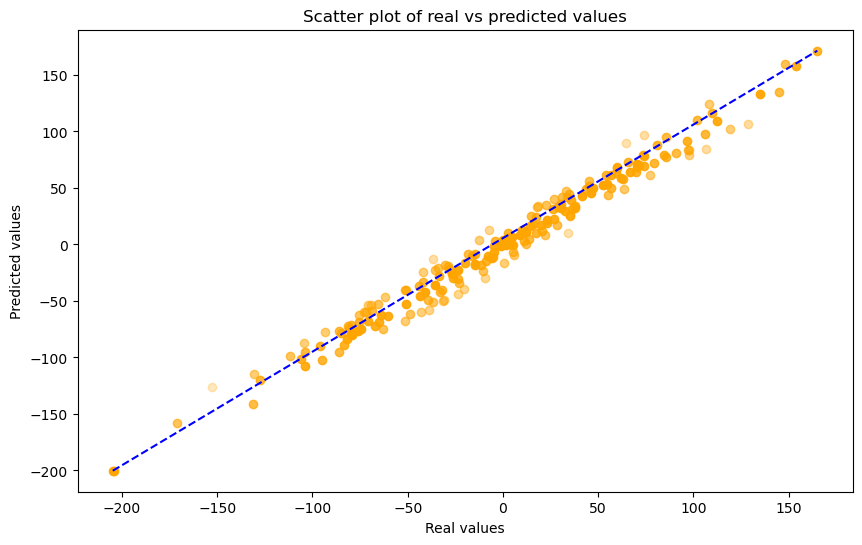

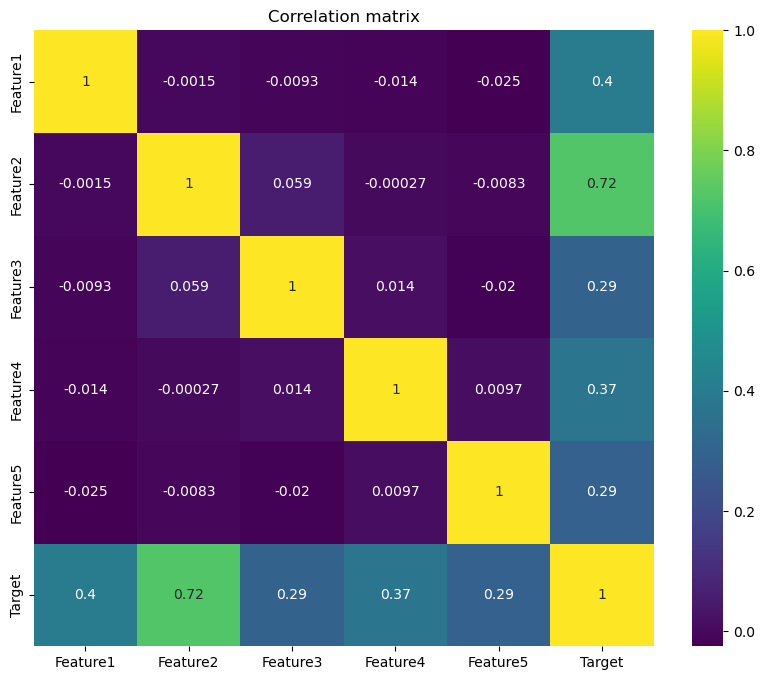

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=5, noise=10, random_state=42)

df = pd.DataFrame(data=X, columns=[f'Feature{i+1}' for i in range(5)])
df['Target'] = y
df.to_csv('dataset1.csv', index = False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMSE = {mse:.2f}, R^2 = {r2:.2f}")

distances = np.abs(y_test - y_pred) # Distance between real and predicted values
max_distance = np.max(distances) # For setting transparency

# Making a plot
plt.figure(figsize=(10, 6))
for i in range(len(y_test)):
    alpha = 1 - (distances[i] / max_distance)  # Transparency which depends on the distance
    plt.scatter(y_test[i], y_pred[i], c='orange', alpha=alpha)

plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], linestyle='--', color = 'blue')
plt.title("Scatter plot of real vs predicted values")
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.show()

# Correlation matrix generation
data = pd.read_csv('dataset1.csv')
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Correlation matrix')
plt.show()

**Частина 2: Аналіз часових даних**

1. Знайдіть набір часових даних в Інтернеті. Це може бути, наприклад, набір даних про ціни на акції, погоду, рух транспорту, або будь-які інші дані, які залежать від часу.

2. Завантажте та візуалізуйте ці дані. Переконайтеся, що ви розумієте основні характеристики часового ряду, такі як тренд, сезонність, аномалії тощо.

3. Використовуйте методи аналізу часових рядів, такі як розкладання на компоненти, автокореляція тощо, для отримання інсайтів і підготовки даних для моделювання.

            Passengers
Date                  
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


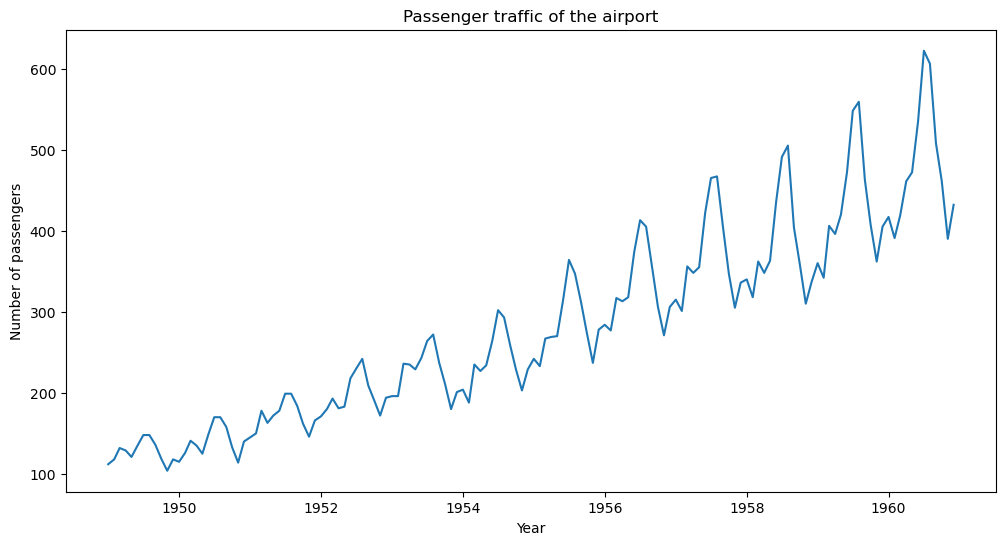

---------- Augmented Dickey-Fuller test: ----------
ADF Statistic: 0.82
p-value: 0.99
Critical values:
1%: -3.48
5%: -2.88
10%: -2.58


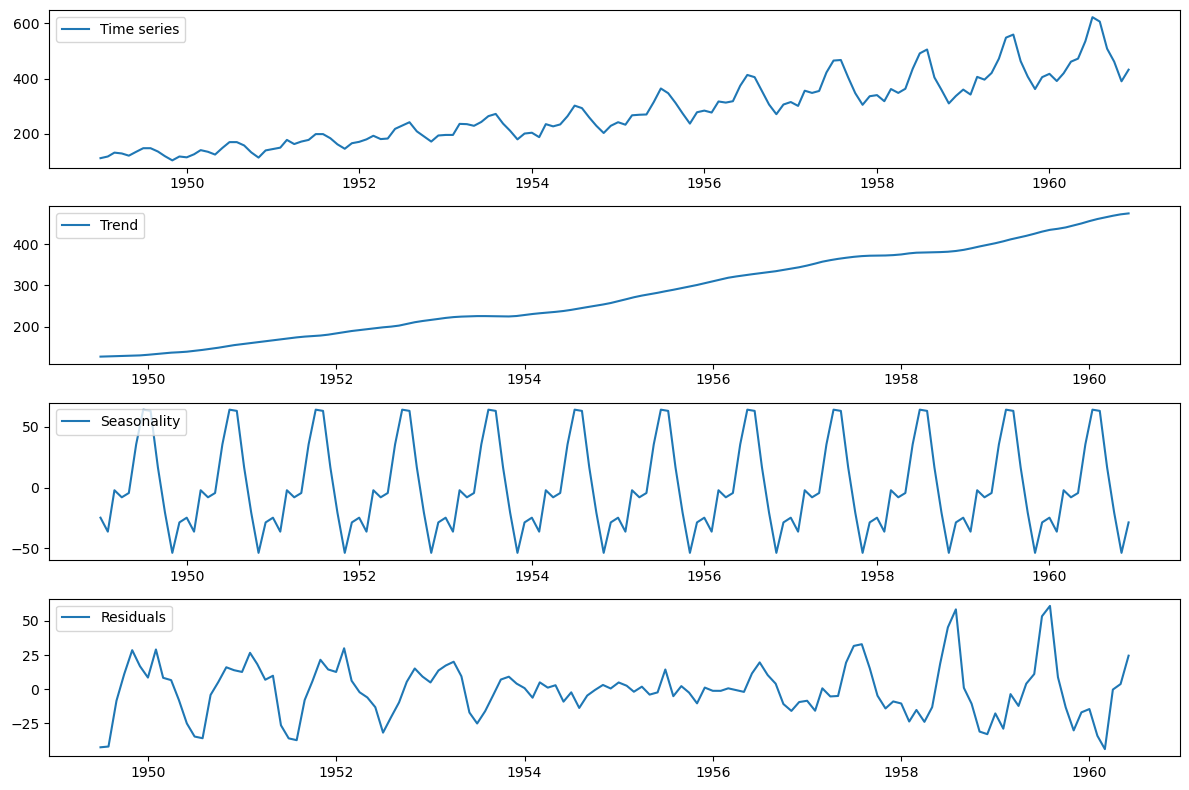

01:32:48 - cmdstanpy - INFO - Chain [1] start processing
01:32:48 - cmdstanpy - INFO - Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
151 1961-07-31  575.744659  546.455068  605.414103
152 1961-08-31  529.327446  499.796171  558.821345
153 1961-09-30  492.512074  465.007832  520.469772
154 1961-10-31  462.466858  434.982208  490.730325
155 1961-11-30  492.123197  463.611282  520.759728

MSE = 505.26, MAE = 17.38


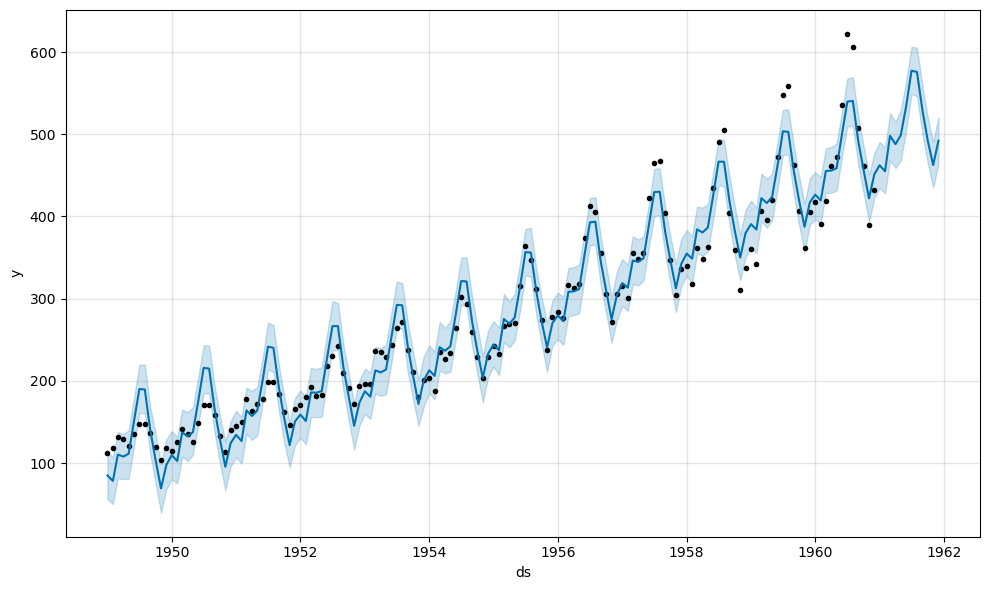

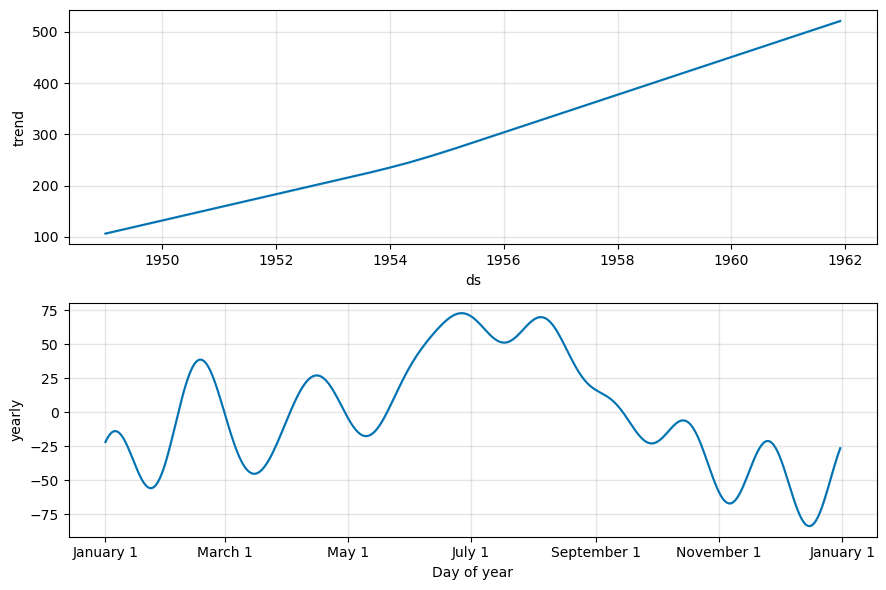

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.simplefilter('ignore')

data = pd.read_csv('air_passengers.csv', parse_dates=['Date'], index_col='Date')
print(data.head())

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Passengers'])
plt.title('Passenger traffic of the airport')
plt.xlabel('Year')
plt.ylabel('Number of passengers')
plt.show()

# Checking the stationarity of the time series
result = adfuller(data)
print("---------- Augmented Dickey-Fuller test: ----------")
print(f'ADF Statistic: {result[0]:.2f}')
print(f'p-value: {result[1]:.2f}')
print('Critical values:')
for key, value in result[4].items():
    print(f'{key}: {value:.2f}')

# Decomposition
decomposition = seasonal_decompose(data, model='additive', period=12)
trend_component = decomposition.trend
seasonality_component = decomposition.seasonal
residuals = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data, label='Time series')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_component, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonality_component, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuals, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Creating the model and training it
data.reset_index(inplace=True)
data.columns = ['ds', 'y'] # Renaming columns for Prophet model
model = Prophet()
model.fit(data)

# Making predictions
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Evaluating the model
metric_df = forecast.set_index('ds')[['yhat']].join(data.set_index('ds').y).reset_index() # building a combined dataframe with yhat from the forecasts and the original y values from the data
metric_df.dropna(inplace=True)
mse = mean_squared_error(metric_df.y, metric_df.yhat)
mae = mean_absolute_error(metric_df.y, metric_df.yhat)
print(f"\nMSE = {mse:.2f}, MAE = {mae:.2f}")

# Making a plot with real values and predicted ones
plot = model.plot(forecast)
components = model.plot_components(forecast)

**Частина 3: Підготовка та аналіз даних на основі файлу AmesHousing.csv (виконується тільки для отримання високої оцінки)**

1. Завантажте файл даних "AmesHousing.csv", який містить інформацію про нерухомість в місті Еймс, штат Айова, США.

2. Вивчіть структуру даних та характеристики ознак. Визначте цільову змінну для регресії (наприклад, ціну житла).

3. Виконайте підготовку даних, таку як обробка відсутніх значень, перетворення категоріальних ознак у числові, масштабування тощо.

4. Побудуйте модель регресії на підготовлених даних і оцініть її точність.

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0       

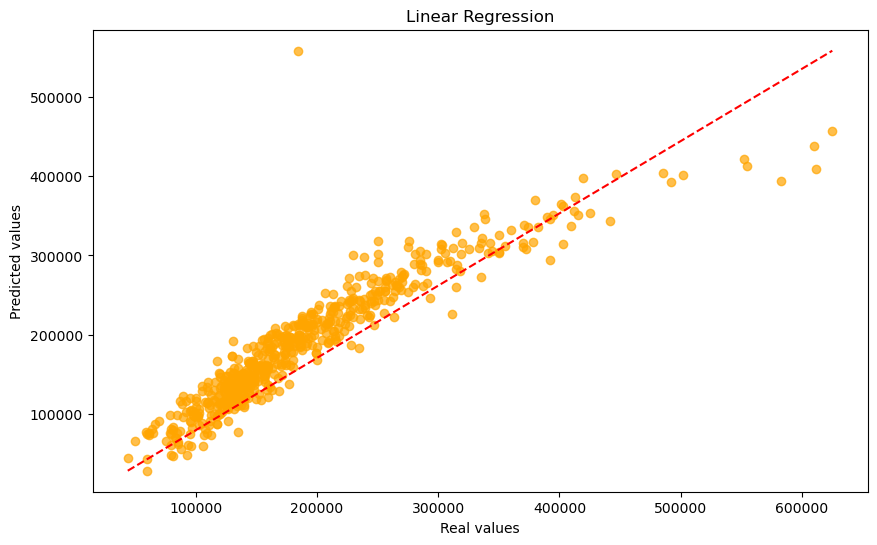

In [95]:
import pandas as pd
from sklearn.calibration import LabelEncoder

data = pd.read_csv("AmesHousing.csv")
print(data.head())

X = data.drop(['SalePrice'], axis=1)
y = data['SalePrice']

# Checkup for missing values
missing_values = X.isnull().sum()
non_zero_missing_values = missing_values[missing_values > 0]
print(non_zero_missing_values)

# Replacement of missing values in numerical features with average values
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
for feature in numeric_features:
    mean = X[feature].mean()
    X[feature].fillna(mean, inplace=True)

# Replacement of missing values in categorical features with numerical values
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"\nR-squared (R^2): {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha = 0.7, color = 'orange')
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], linestyle='--', color = 'red')
plt.title("Linear Regression")
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.show()

